# Multiple Schemas


## Goals

As mentioned, state schema contains the graph's input and output keys. So far, we only consider a single schema for a graph. However, there are cases where we may want a bit more control over this:

* Internal nodes may pass information that is *not required* in the graph's input / output.

* We may also want to use different input / output schemas for the graph. The output might, for example, only contain a single relevant output key.

We'll discuss a few ways to customize graphs with multiple schemas.

### Private state

By default, `StateGraph` takes in a single schema and all nodes are expected to communicate with that schema. However, in some cases, you may want nodes to exchange information that is crucial for intermediate logic but doesn’t need to be part of the main schema of the graph. This private data is not relevant to the overall input/output of the graph and should only be shared between certain nodes. For this type of data, we can define specific schamas, called [private state](https://langchain-ai.github.io/langgraph/how-tos/pass_private_state/).

### Input / Output Schema

It is also possible to define explicit [input and output schemas](https://langchain-ai.github.io/langgraph/how-tos/input_output_schema/?h=input+outp).

Often, in these cases, we define an "internal" schema that contains *all* keys relevant to graph operations.

But, we use specific `input` and `output` schemas to constrain the input and output.

In [2]:
from langgraph.graph import StateGraph, START, END
from typing_extensions import TypedDict
from IPython.display import Image, display


# The overall state of the graph (this is the public state shared across nodes)
class OverallState(TypedDict):
    a: str


# Output from node_1 contains private data that is not part of the overall state
class Node1Output(TypedDict):
    private_data: str


# The private data is only shared between node_1 and node_2
def node_1(state: OverallState) -> Node1Output:
    output = {"private_data": "set by node_1"}
    print(f"Entered node `node_1`:\n\tInput: {state}.\n\tReturned: {output}")
    return output


# Node 2 input only requests the private data available after node_1
class Node2Input(TypedDict):
    private_data: str


def node_2(state: Node2Input) -> OverallState:
    output = {"a": "set by node_2"}
    print(f"Entered node `node_2`:\n\tInput: {state}.\n\tReturned: {output}")
    return output

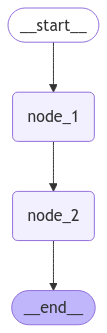

In [3]:
builder = StateGraph(OverallState)

# create nodes
builder.add_node('node_1', node_1)
builder.add_node('node_2', node_2) # it accepts private data from node_1

# create edges
builder.add_edge(START, 'node_1')
builder.add_edge('node_1', 'node_2') 
builder.add_edge('node_2', END)

graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [4]:
graph.invoke({'a': "set at start"})

Entered node `node_1`:
	Input: {'a': 'set at start'}.
	Returned: {'private_data': 'set by node_1'}
Entered node `node_2`:
	Input: {'private_data': 'set by node_1'}.
	Returned: {'a': 'set by node_2'}


{'a': 'set by node_2'}

`private_data` is only included in `PrivateState`.

`node_2` uses `PrivateState` as input, but writes out to `OverallState`.

So, we can see that `private_data` is excluded from the graph output because it is not in `OverallState`.

## Input / Output Schema

By default, `StateGraph` takes in a single schema and all nodes are expected to communicate with that schema. 

However, it is also possible to [define explicit input and output schemas for a graph](https://langchain-ai.github.io/langgraph/how-tos/input_output_schema/?h=input+outp).

Often, in these cases, we define an "internal" schema that contains *all* keys relevant to graph operations.

But, we use specific `input` and `output` schemas to constrain the input and output.

First, let's just run the graph with a single schema.